In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps
import pickle

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline


tfd = tfp.distributions


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from datasets import *

In [3]:
data_set_small = load_data_set('./datasets/100.10')
data_set_big = load_data_set('./datasets/100.100')

In [4]:
%%writefile basic_solutions.py

import numpy as np
from scipy.optimize import minimize

def bayesian_solve(alpha0, beta0, train, L):
    return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)

def calc_loglike(p_pred, val, L):
    return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()

def calc_bayesian_solve_loglike(alpha0, beta0, train, val, L):
    p_pred = bayesian_solve(alpha0, beta0, train, L)
    return calc_loglike(p_pred, val, L)

def stupid_solution(train, val, L):
    return (train + val + 1e-4) / 2 / (L + 2e-4)

def evaluate(solution_fun, train, val, test, L):
    p_pred = solution_fun(train, val, L)
    p_const = (train.sum() + val.sum()) / L / 2 / train.shape[0]
    return (calc_loglike(p_pred, test, 1e6) - calc_loglike(p_const, test, 1e6)) / 1e6 / test.shape[0]

def max_loglike_solution(train, val, L):
    loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], train, val, L)
    res = minimize(fun=lambda x: -loglike(1 + np.exp(x)), x0=(1, 1))
    if not res.success:
        return stupid_solution(train, val, L)
    else:
        return bayesian_solve(1 + np.exp(res.x[0]), 1 + np.exp(res.x[1]), train + val, L * 2)

Overwriting basic_solutions.py


In [5]:
from basic_solutions import *

evaluate(stupid_solution, data_set_small.train_data[0], data_set_small.test_data[0], data_set_small.ideal[0], data_set_small.L)

0.018340855186884244

In [43]:
def calibration_curve_solution(train, val, L):
    line = sps.linregress(val / L, train / L)
    tg = 1 / line.slope
    sum_ab = tg * L - L + 2
    m = ((train + val) / 2 / L).mean()
    if m * sum_ab < 1:
        sum_ab = 1 / m * 20
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)
    
def pceudo_cc_solution(train, val, L):
    m = ((train + val) / 2. / L).mean()
    sq_std = ((train + val) / 2. / L).std() ** 2
    sum_ab = m * (1 - m)/ sq_std
    if m * sum_ab < 1:
        sum_ab = 1 / m * 20
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)
    
def max_loglike_solution2(train, val, L):
    loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], train, val, L)
    res = minimize(fun=lambda x: -loglike(1 + np.exp(x)), x0=(1, 1))
    if not res.success:
        return stupid_solution(train, val, L)
    else:
        return bayesian_solve(1 + np.exp(res.x[0]), 1 + np.exp(res.x[1]), train, L)

In [48]:
def evaluate_compare(solutions, ds, plot=False, labels=[]):
    llps = [[] for _ in solutions]
    for t_id in range(ds.train_data.shape[0]):
        for i, solution in enumerate(solutions):
            score = evaluate(solution, ds.train_data[t_id], ds.test_data[t_id], ds.ideal[t_id], ds.L)
            llps[i].append(score)

            
    min_ = 1e9
    max_ = -1e9
    ans = []
    
    good = np.ones(len(llps[0]), dtype=np.bool)
    for solution_scores in llps:
        sc = np.array(solution_scores)
        good &= sc == sc
        good &= sc != np.inf
        good &= sc != float("-inf")
    
    for solution_scores in llps:
        sc = np.array(solution_scores)
        ans.append((sc[good].mean(), good.sum()))
        min_ = min(min_, sc[good].min())
        max_ = max(max_, sc[good].max())

        
    if plot:
        for i, label in enumerate(labels):
            plt.hist(llps[i], bins=20, alpha=0.5, label=label, range=(min_, max_))
        plt.legend()
        plt.grid()
        plt.show()
        
    return ans

10


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_laun

/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountere

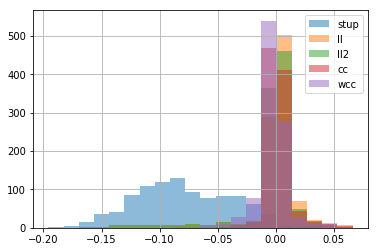

(-0.079767172456796, 981)
(-0.00121525722710788, 981)
(-0.00279439458381583, 981)
(0.002736666351717865, 981)
(-0.0017990651792671038, 981)
20


/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by 

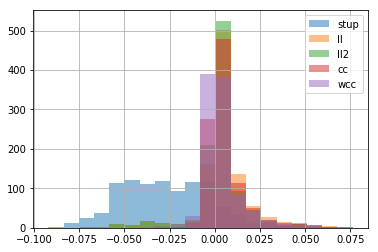

(-0.026371866216203823, 991)
(0.004766146323020353, 991)
(0.0030370548155002363, 991)
(0.006050145691021331, 991)
(0.004085337523526584, 991)
30


/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide 

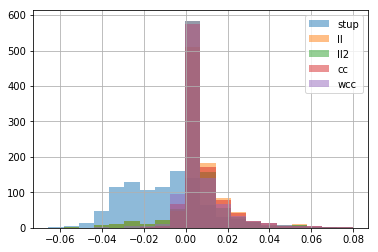

(-0.009902108475365944, 994)
(0.006613122565713246, 994)
(0.005058458130917101, 994)
(0.0076851248122072535, 994)
(0.00652648144504112, 994)
50


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: invalid v

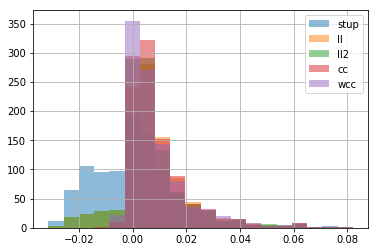

(0.00154154186593994, 998)
(0.007896222786746523, 998)
(0.006763524513521789, 998)
(0.009334388361811361, 998)
(0.009033468618220995, 998)
70


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: invalid value e

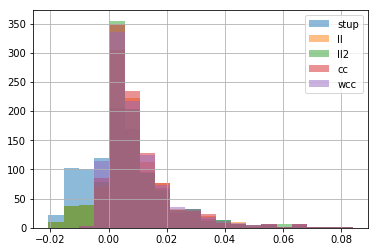

(0.005941532216656673, 998)
(0.009028362363172927, 998)
(0.008110635908062826, 998)
(0.0103270032343024, 998)
(0.010183973358827682, 998)
100


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:10

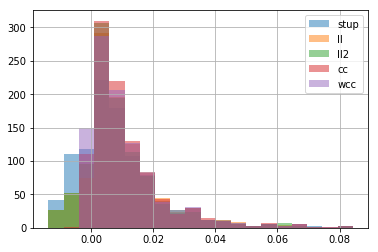

(0.008753492967146895, 998)
(0.010260208425350087, 998)
(0.009494124156292588, 998)
(0.01105912566864227, 998)
(0.011017228052428506, 998)
150


/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: invalid value encountered in multiply
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_

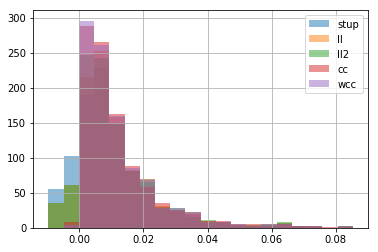

(0.01066155459328144, 998)
(0.011390701974639983, 998)
(0.010772840721949896, 998)
(0.01172436299852723, 998)
(0.011830204231739649, 998)
200


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: invalid value encountered in multip

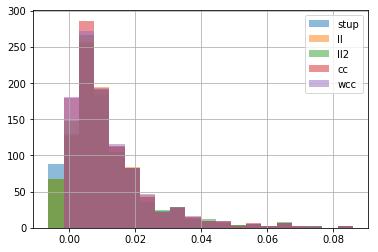

(0.011502297838903027, 999)
(0.011824447706015028, 999)
(0.011340224469894335, 999)
(0.012057706257688938, 999)
(0.012209955622840163, 999)
300


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: 

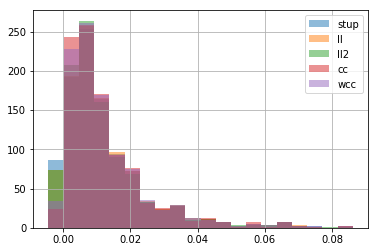

(0.012297939308330497, 999)
(0.012457335768344168, 999)
(0.01207320245469442, 999)
(0.012491737841711198, 999)
(0.012635317232552661, 999)
500


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWar

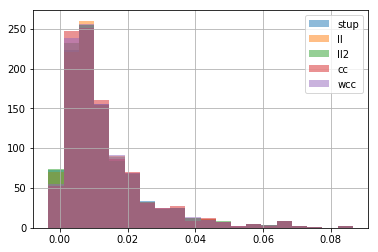

(0.012860802202906578, 999)
(0.012909074269761798, 999)
(0.012672100900649122, 999)
(0.012850810782066405, 999)
(0.012984010895983394, 999)
1000


/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: divide by zero encountered in log
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/dip/bachelor/basic_solutions.py:9: RuntimeWarning: invalid value encountered in multiply
  return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/aapopovkin/venv/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarn

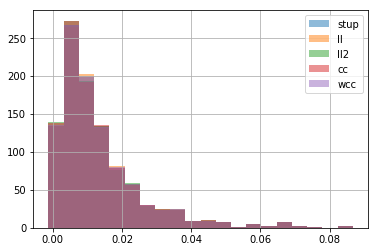

(0.013219719789490072, 999)
(0.013233286105760775, 999)
(0.013099569985027398, 999)
(0.01317874145934623, 999)
(0.01325050015059707, 999)
1500


/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


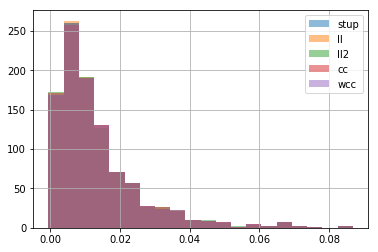

(0.01332861128981367, 999)
(0.01333393259202242, 999)
(0.013236826215022103, 999)
(0.013290022588326915, 999)
(0.01333861514440353, 999)
2000


/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


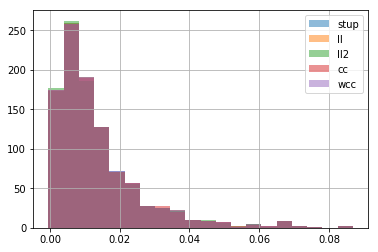

(0.01338052902286831, 999)
(0.01338335620257947, 999)
(0.01331110266399262, 999)
(0.013349257138109954, 999)
(0.013385306773872169, 999)


In [49]:
for L in [10, 20, 30, 50, 70, 100, 150, 200, 300, 500, 1000, 1500, 2000]:
    print (L)
    ans = evaluate_compare([
            stupid_solution,
            max_loglike_solution,
            max_loglike_solution2,
            calibration_curve_solution,
            pceudo_cc_solution,
        ], DataSet(1000, 100, L), True, [
            'stup', 'll', 'll2', 'cc', 'wcc'
        ])
    for i in ans:
        print (i)

/home/aapopovkin/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aapopovkin/dip/bachelor/basic_solutions.py:6: RuntimeWarning: invalid value encountered in true_divide
  return (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)


0.031018558135350382
-0.026968268731682482
0.004050289403667896
100


/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aapopovkin/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


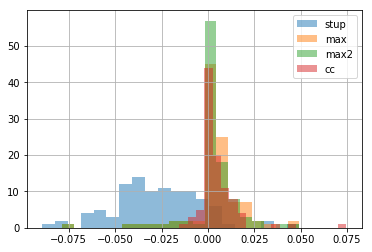

In [50]:
win = []
b = []
m = []
m2 = []
c = []
ds = data_set_big
for i in range(100):
    b_ = evaluate(stupid_solution, ds.train_data[i], ds.test_data[i], ds.ideal[i], ds.L)
    m_ = evaluate(max_loglike_solution, ds.train_data[i], ds.test_data[i], ds.ideal[i], ds.L)
    m2_ = evaluate(max_loglike_solution2, ds.train_data[i], ds.test_data[i], ds.ideal[i], ds.L)
    c_ = evaluate(calibration_curve_solution, ds.train_data[i], ds.test_data[i], ds.ideal[i], ds.L)
    if b_ == float('inf'):
        continue
    #print (b, m)
    b.append(b_)
    m.append(m_)
    m2.append(m2_)
    c.append(c_)
    win.append(m_ - b_)
print (np.mean(win))
print (np.mean(b))
print (np.mean(m))
print (len(m))
plt.hist(b, bins=20, alpha=0.5, label='stup')
plt.hist(m, bins=20, alpha=0.5, label='max')
plt.hist(m2, bins=20, alpha=0.5, label='max2')
plt.hist(c, bins=20, alpha=0.5, label='cc')
plt.legend()
plt.grid()
plt.show()

In [10]:
loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], data_set_small, 0)

In [11]:
data_set_small.alpha0[0], data_set_small.beta0[0]

(1.1288500225383182, 15.889671468585249)

In [12]:
plt.figure(figsize=(17, 6))
for i in np.linspace(1, 2, 5):
    space = np.linspace(1, 20, 100)
    plt.plot(space, [loglike((i, s)) for s in space], label=str(i))
    
plt.grid()
plt.legend()
plt.show()

TypeError: calc_bayesian_solve_loglike() missing 1 required positional argument: 'L'

<Figure size 1224x432 with 0 Axes>

In [ ]:
max([
        loglike((x, y)) for x in np.linspace(1, 2, 100) for y in np.linspace(1, 30, 200)
])

In [ ]:
minimize(fun=lambda x: -loglike(x), x0=(1, 1))

In [ ]:
def formulae(train, val, L):
    return L * val.shape[0] / val.sum() - 1, L * val.shape[0] / (L * val.shape[0] - val.sum()) - 1
    return U1

for i in range(10):
    a = formulae(data_set_small.train_data[i], data_set_small.val_data[i], data_set_small.L)
    print (a[0] * a[1])

In [ ]:
for i in range(10):
    res = minimize(fun=lambda x: -calc_bayesian_solve_loglike(1 + np.exp(x[0]), 1 + np.exp(x[1]), data_set_small, i), x0=(1.1, 2.1))
    print (1 + np.exp(res.x), res.success)
    print(data_set_small.alpha0[i], data_set_small.beta0[i])
    print (-res.fun)
    print (max([
        calc_bayesian_solve_loglike(1 + np.exp(x), 1 + np.exp(y), data_set_small, i)
        for x in np.linspace(1, 5, 30) for y in np.linspace(1, 200, 1000)
    ]))